# Monthly milk production 

First, let's load a data:

In [22]:
# separate out a validation dataset
from pandas import read_csv
series = read_csv('milk.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 156, Validation 12


I'll try to predict the last 12 months of set. Let's take a look at the data.

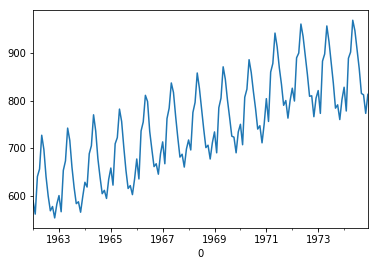

In [23]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
series.plot()
pyplot.show()

Seems Ok

# ARIMA
or Autoregressive Integrated Moving Average
### 1. step
Manually Configure the ARIMA.

ADF Statistic: -2.461257
p-value: 0.125188
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579


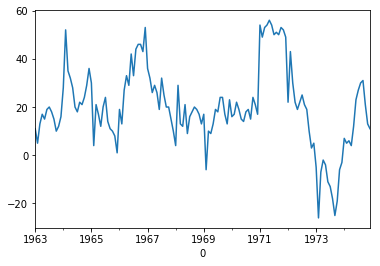

In [24]:
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header=False)
# plot
stationary.plot()
pyplot.show()

The plot does not show any obvious seasonality or trend, suggesting the seasonally differenced dataset is a good starting point for modeling.

### 2. step
Automatically Configure the ARIMA

In [25]:
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=16.822
ARIMA(0, 0, 2) RMSE=13.900
ARIMA(0, 0, 3) RMSE=11.851
ARIMA(0, 0, 4) RMSE=11.358
ARIMA(0, 0, 5) RMSE=10.120
ARIMA(0, 0, 6) RMSE=10.069
ARIMA(0, 1, 1) RMSE=8.773
ARIMA(0, 1, 2) RMSE=8.813
ARIMA(0, 1, 3) RMSE=8.839
ARIMA(0, 1, 4) RMSE=8.987
ARIMA(0, 1, 5) RMSE=8.996
ARIMA(0, 2, 1) RMSE=8.918
ARIMA(1, 0, 0) RMSE=8.809
ARIMA(1, 0, 1) RMSE=8.732
ARIMA(1, 0, 2) RMSE=8.763
ARIMA(1, 0, 3) RMSE=8.798
ARIMA(1, 1, 0) RMSE=8.749
ARIMA(1, 1, 1) RMSE=8.797
ARIMA(1, 2, 0) RMSE=11.220
ARIMA(1, 2, 1) RMSE=8.810
ARIMA(1, 2, 2) RMSE=8.856
ARIMA(2, 0, 0) RMSE=8.706
ARIMA(2, 0, 1) RMSE=8.745
ARIMA(2, 1, 0) RMSE=8.801
ARIMA(2, 2, 0) RMSE=10.058
ARIMA(2, 2, 1) RMSE=8.886
ARIMA(3, 0, 0) RMSE=8.764
ARIMA(3, 1, 0) RMSE=8.796
ARIMA(3, 2, 0) RMSE=9.764
ARIMA(3, 2, 1) RMSE=8.838
ARIMA(3, 2, 2) RMSE=8.882
ARIMA(4, 0, 0) RMSE=8.739
ARIMA(4, 0, 1) RMSE=8.760
ARIMA(4, 1, 0) RMSE=8.853
ARIMA(4, 1, 1) RMSE=9.042
ARIMA(4, 1, 2) RMSE=9.020
ARIMA(4, 2, 0) RMSE=9.695
ARIMA(4, 2, 1) RMSE=8.897
ARIM

Where RMSE is the root mean squared error. The best one is the smallest one: ARIMA(2,0,0) with RMSE = 8.706.

### 3. step
Review Residual Errors
deally, the distribution of residual errors should be a Gaussian with a zero mean.

               0
count  78.000000
mean    0.807252
std     8.724909
min   -26.456985
25%    -3.521626
50%     1.017328
75%     4.881541
max    36.647271


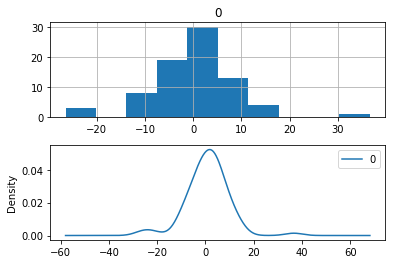

In [26]:
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,0,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

The Gauss-Markov assumptions are satisfied, so I have a model to check. 

## Validate model

The part below saves the fit model to file in the correct state so that it can be loaded successfully later.

In [32]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(2,0,0))
model_fit = model.fit(trend='nc', disp=0)
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy')

Now we can load the model that was saved before and make a prediction.

>Predicted=838.889, Expected=834
>Predicted=784.837, Expected=782
>Predicted=893.247, Expected=892
>Predicted=905.070, Expected=903
>Predicted=970.405, Expected=966
>Predicted=945.072, Expected=937
>Predicted=900.108, Expected=896
>Predicted=856.079, Expected=858
>Predicted=805.805, Expected=817
>Predicted=811.471, Expected=827
>Predicted=784.507, Expected=797
>Predicted=833.976, Expected=843
RMSE: 7.889


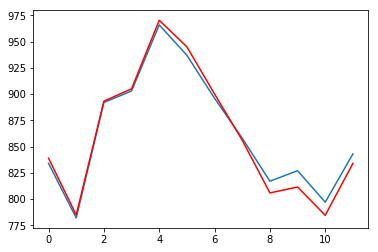

In [35]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,0,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

Finnaly, the predicted values for each month are on the graph above. Where red line is a predicted values and blue line is reality.

## Drafts

Each line is month

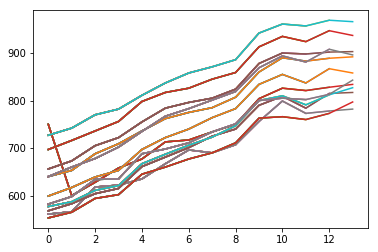

In [59]:
# separate out a validation dataset
from pandas import read_csv
sortedmilk = []
series = read_csv('milk.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
for i in range(0,12):
    temp = []
    for j in range(0,14):
        sortedmilk += [series[i+j*12]]
        temp += [series[i+j*12]]
        pyplot.plot(temp, label=i+1)
        #print(i+j*12, series[i+j*12])
#dataset, validation = series[0:split_point], series[split_point:]
#print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
#print(sortedmilk)
pyplot.show()

Each line is a year

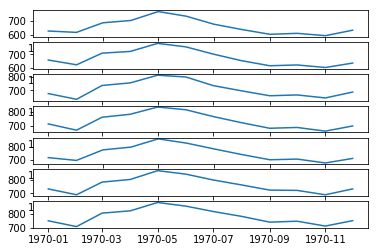

In [56]:
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
pyplot.figure()
pyplot.title('Year-to-Year Pattern')
i = 1
n_groups = len(groups)
for name, group in groups:
	pyplot.subplot((n_groups*100) + 10 + i)
	i += 1
	pyplot.plot(group)
pyplot.show()